In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical

def load_data_from_mat(path):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    for file in os.listdir(path):
        if file.startswith('train_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            train_data.append(mat[list(mat.keys())[-2]])  # Assuming data is the second last key
            train_labels.append(mat[list(mat.keys())[-1]])  # Assuming label is the last key
        elif file.startswith('test_'):
            mat = scipy.io.loadmat(os.path.join(path, file))
            test_data.append(mat[list(mat.keys())[-2]])
            test_labels.append(mat[list(mat.keys())[-1]])

    # Concatenate all data and labels respectively
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_labels = np.concatenate(test_labels, axis=0)

    # Normalize data
    train_data = train_data.astype('float32') / 255
    test_data = test_data.astype('float32') / 255

    # Convert labels to categorical (one-hot encoding)
    train_labels = to_categorical(train_labels, 10)
    test_labels = to_categorical(test_labels, 10)

    return train_data, train_labels, test_data, test_labels


def apply_fft_and_split(data):
    """
    对数据执行一维FFT变换，并分离实部和虚部。
    
    Parameters:
    - data: 形状为 (n_samples, n_features) 的数组
    
    Returns:
    - FFT变换后数据的实部和虚部
    """
    fft_data = np.fft.fft(data, axis=-1)
    return np.real(fft_data), np.imag(fft_data)

In [2]:
# 调用函数加载数据
path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/'
train_data, train_labels, test_data, test_labels = load_data_from_mat(path)

train_data_origin = train_data
test_data_origin = test_data

# train_data_z = train_data / np.max(train_data)
# test_data_z = test_data / np.max(test_data)

# 应用FFT变换并分离实部和虚部
train_data_fft_real, train_data_fft_imag = apply_fft_and_split(train_data)
test_data_fft_real, test_data_fft_imag = apply_fft_and_split(test_data)

# 合并实部和虚部为模型的输入
train_data_fft_combined = np.concatenate((train_data_fft_real, train_data_fft_imag), axis=-1)
test_data_fft_combined = np.concatenate((test_data_fft_real, test_data_fft_imag), axis=-1)

def compute_magnitude_phase(data_fft_real, data_fft_imag):
    magnitude = np.sqrt(data_fft_real**2 + data_fft_imag**2)
    phase = np.arctan2(data_fft_imag, data_fft_real)
    return magnitude, phase

# 假设 train_data_fft_real 和 train_data_fft_imag 是你之前计算的FFT变换的实部和虚部
train_magnitude, train_phase = compute_magnitude_phase(train_data_fft_real, train_data_fft_imag)
test_magnitude, test_phase = compute_magnitude_phase(test_data_fft_real, test_data_fft_imag)

# 将幅度和相位合并为模型输入
# train_data_combined = np.concatenate((train_magnitude, train_phase), axis=-1)
# test_data_combined = np.concatenate((train_magnitude, train_phase), axis=-1)

half_train_magnitude = train_magnitude[:, :1536]
half_test_magnitude = test_magnitude[:, :1536]
half_train_data_fft_real = train_data_fft_real[:, :1536]
half_train_data_fft_imag = train_data_fft_imag[:, :1536]
half_test_data_fft_real = test_data_fft_real[:, :1536]
half_test_data_fft_imag = test_data_fft_imag[:, :1536]
# print(train_magnitude.shape)
# print(half_train_phase.shape)
# 然后可以用这些数据来训练你的模型
train_data_combined = np.concatenate((half_train_magnitude, half_train_data_fft_real, half_train_data_fft_imag), axis=-1)
test_data_combined = np.concatenate((half_test_magnitude, half_test_data_fft_real, half_test_data_fft_imag), axis=-1)
print(train_data_combined.shape)
print(test_data_combined.shape)
train_data_fft_reshaped = train_data_combined.reshape((-1, 32, 48, 3))
test_data_fft_reshaped = test_data_combined.reshape((-1, 32, 48, 3))
print('Train data shape:', train_data_fft_reshaped.shape)
print('Test data shape:', test_data_fft_reshaped.shape)

(126000, 4608)
(14000, 4608)
Train data shape: (126000, 32, 48, 3)
Test data shape: (14000, 32, 48, 3)


In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def build_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

# 注意：根据你的数据调整input_shape
model = build_resnet_model(input_shape=(32, 48, 3), num_classes=10)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 54, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 12, 64) │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 12, 64) │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 12, 64) │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 12, 64) │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 12, 64) │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 12, 64) │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 12, 64) │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 12,     │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 12,     │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 12,     │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 12,     │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 24,061,706 (91.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [4]:
import numpy as np

# 假设 train_data_reshaped 和 train_labels 是你的完整训练数据和标签

# sample_size = 18000*7  # 选择一个适合你计算资源的样本大小
# indices = np.random.choice(range(len(train_data_reshaped)), sample_size, replace=False)

# train_data_sample = train_data_reshaped[indices]
# train_labels_sample = train_labels[indices]

# 然后使用这个更小的数据集进行训练
history = model.fit(train_data_fft_reshaped, train_labels, validation_split=0.1, epochs=30, batch_size=64, shuffle = True)


Epoch 1/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 980s 546ms/step - accuracy: 0.6713 - loss: 0.8083 - val_accuracy: 0.2971 - val_loss: 3.9053
Epoch 2/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 945s 533ms/step - accuracy: 0.8167 - loss: 0.3894 - val_accuracy: 0.5806 - val_loss: 1.7524
Epoch 3/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 951s 537ms/step - accuracy: 0.8440 - loss: 0.3416 - val_accuracy: 0.2857 - val_loss: 10.6464
Epoch 4/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 960s 542ms/step - accuracy: 0.8459 - loss: 0.3567 - val_accuracy: 0.7233 - val_loss: 0.6814
Epoch 5/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 990s 559ms/step - accuracy: 0.8816 - loss: 0.2849 - val_accuracy: 0.4602 - val_loss: 4.4096
Epoch 6/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 933s 526ms/step - accuracy: 0.9009 - loss: 0.2393 - val_accuracy: 0.8296 - val_loss: 0.4340
Epoch 7/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 923s 521ms/step - accuracy: 0.9043 - loss: 0.2321 - val_accuracy: 0.8903 - val_loss: 0.2812
Epoch 8/30
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 948s 535ms/step - a

In [5]:
model.save('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-resNet.h5')  # HDF5文件
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/FFT-resNet.h5')

In [6]:
# 评估模型在测试集上的性能
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)

print(f'测试集损失: {test_loss}')
print(f'测试集准确率: {test_acc}')


438/438 - 31s - 70ms/step - accuracy: 0.8731 - loss: 0.4479
测试集损失: 0.44788891077041626
测试集准确率: 0.8730714321136475


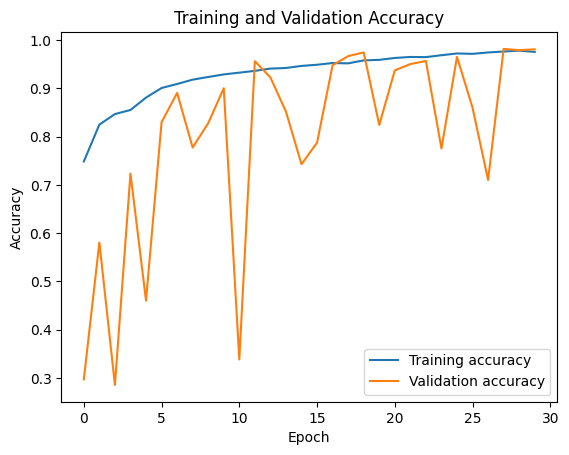

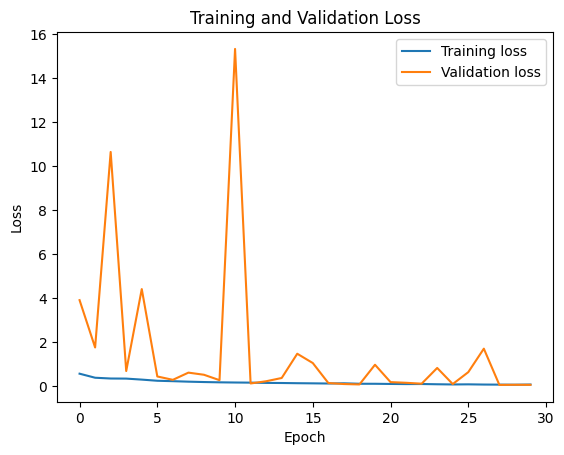

In [7]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

438/438 - 25s - 58ms/step - accuracy: 0.8731 - loss: 0.4479

Test accuracy: 0.8730714321136475
438/438 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step
              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1400
           1       1.00      1.00      1.00      1400
           2       0.98      0.97      0.98      1400
           3       0.95      0.89      0.92      1400
           4       1.00      1.00      1.00      1400
           5       1.00      0.96      0.98      1400
           6       0.77      0.90      0.83      1400
           7       1.00      1.00      1.00      1400
           8       0.68      0.54      0.60      1400
           9       0.58      0.74      0.65      1400

    accuracy                           0.87     14000
   macro avg       0.88      0.87      0.87     14000
weighted avg       0.88      0.87      0.87     14000



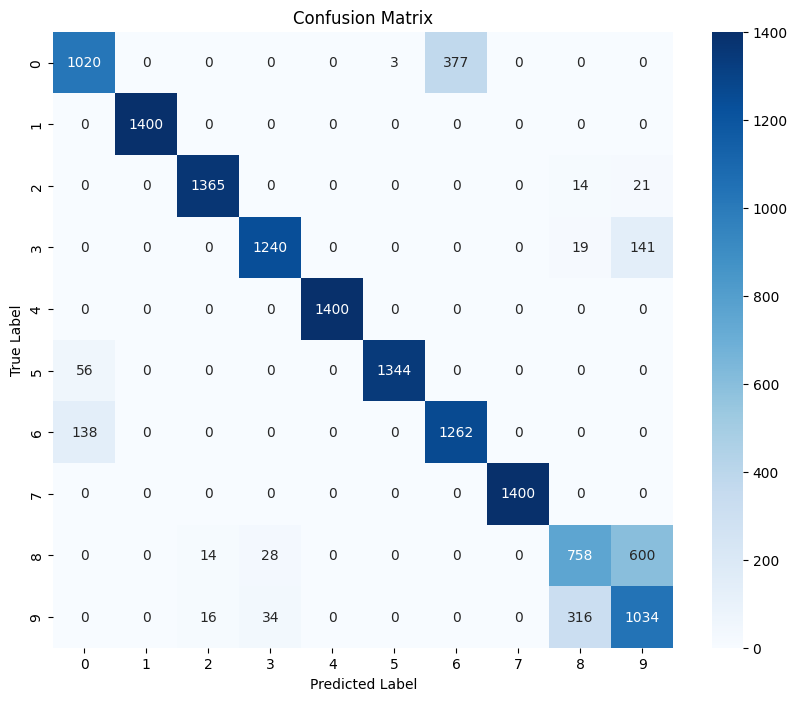

In [8]:
import scipy.io
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



# 确保在这里使用测试数据和测试标签
test_loss, test_acc = loaded_model.evaluate(test_data_fft_reshaped, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# 预测测试数据集
predictions = loaded_model.predict(test_data_fft_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels.argmax(axis=1), predicted_classes, target_names=[str(i) for i in range(10)])
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()